## Item 1
Deberá ejecutar tres algoritmos de clustering: K-Means, K-Means++ y
MeanShift, utilizando al menos cuatro configuraciones distintas para cada técnica
(deberá justificar la elección de parámetros). Para el entrenamiento, use únicamente
el 80% de los datos, omitiendo la etiqueta Y. A continuación, evalúe las doce
configuraciones obtenidas mediante una métrica de su elección (por ejemplo,
Silhouette Score) y seleccione las tres de mejor desempeño. Luego, aplique cada
una de estas configuraciones al 20% restante de los datos, asignando a cada muestra
el cluster correspondiente (obtenidos desde el entrenamiento). Finalmente, compare
la etiqueta Y real de cada muestra con la etiqueta dominante dentro del cluster al
que pertenece y analice si este procedimiento resulta razonable para asignar
etiquetas faltantes.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, classification_report


In [25]:
housing = fetch_california_housing()
x = housing.data
x = StandardScaler().fit_transform(x)
df_x = pd.DataFrame(x, columns=housing.feature_names)

y = housing.target
y = pd.qcut(y, q=4, labels=[0,1,2,3])

Q1 = df_x.quantile(0.25)
Q3 = df_x.quantile(0.75)
IQR = Q3 - Q1
mask = ((df_x >= (Q1 - 1.5 * IQR)) & (df_x <= (Q3 + 1.5 * IQR))).all(axis=1)

x = df_x[mask].values
y = y[mask]

train_data, test_data, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

df_housing = pd.DataFrame(train_data, columns=housing.feature_names)
df_price = pd.DataFrame(y_train, columns=['MedHouseVal'])

print(df_price.head())
print(df_housing.head())
print(df_price.shape)
print(df_housing.shape)

  MedHouseVal
0           0
1           2
2           1
3           2
4           2
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.692224  1.856182 -0.164209  -0.225314   -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618  -0.331023    1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903  -0.061124   -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052  -0.104967   -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353  -0.096247   -0.607078  0.006718 -0.642287   

   Longitude  
0  -1.218026  
1   0.409140  
2   0.678670  
3   0.843383  
4   0.553888  
(13473, 1)
(13473, 8)


## Mean-shift

In [26]:
from sklearn.cluster import estimate_bandwidth, get_bin_seeds, MeanShift

In [27]:
def MeanShift_Clustering(quantile, n_samples):
    qt = quantile
    nsamples = n_samples
    bandwidth = estimate_bandwidth(train_data, quantile=qt, n_samples=nsamples)
    # quantile es el porcentaje de puntos que se consideran vecinos (Sensibilidad)

    seeds = get_bin_seeds(train_data, bin_size=bandwidth, min_bin_freq=1)
    #Ajusta la cantidad de puntos iniciales (semillas) para el algoritmo

    # <-- Mean Shift Clustering -->
    ms = MeanShift(bandwidth=bandwidth, seeds=seeds)
    ms.fit(train_data)
    labels = ms.labels_
    n_clusters_ = len(np.unique(labels))
    print("Number of estimated clusters: %d" % n_clusters_)

    # <-- Evaluación del clustering -->
    silhouette_vals = silhouette_score(train_data, labels)
    print(f'Silhouette Score: {silhouette_vals}')
    
    return [ms,silhouette_vals]

In [28]:
scores = []
score_1 = MeanShift_Clustering(quantile=0.06, n_samples=10000)
scores.append(score_1)

Number of estimated clusters: 2
Silhouette Score: 0.3835299045591097


In [29]:
# Prueba 2
score_2 = MeanShift_Clustering(quantile=0.03, n_samples=10000)
scores.append(score_2)

Number of estimated clusters: 5
Silhouette Score: 0.19887290757320947


In [30]:
# Prueba 3
score_3 = MeanShift_Clustering(quantile=0.06, n_samples=1000)
scores.append(score_3)

Number of estimated clusters: 2
Silhouette Score: 0.3834764190005846


In [31]:
# Prueba 4
score_4 = MeanShift_Clustering(quantile=0.01, n_samples=10000)
scores.append(score_4)

Number of estimated clusters: 32
Silhouette Score: 0.07948843666030442


#

## K-Means

In [32]:
from sklearn.cluster import KMeans

In [33]:
def kmeans_clustering(k):
    train_data_kmeans = pd.DataFrame(train_data)
    kmeans = KMeans(n_clusters=k, init='random', random_state=42)
    kmeans.fit(train_data_kmeans)
    kmeans_labels = kmeans.labels_
    print(train_data_kmeans.head())
    print(len(np.unique(kmeans_labels)))

    # <-- Evaluación del clustering -->
    silhouette_vals = silhouette_score(train_data, kmeans_labels)
    print(f'Silhouette Score: {silhouette_vals}')
    return [kmeans, silhouette_vals]

In [34]:
score_k1 = kmeans_clustering(k=4)
scores.append(score_k1)

          0         1         2         3         4         5         6  \
0 -0.692224  1.856182 -0.164209 -0.225314 -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618 -0.331023  1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903 -0.061124 -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052 -0.104967 -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353 -0.096247 -0.607078  0.006718 -0.642287   

          7  
0 -1.218026  
1  0.409140  
2  0.678670  
3  0.843383  
4  0.553888  
4
Silhouette Score: 0.26797226891963394


In [35]:
score_k2 = kmeans_clustering(k=2)
scores.append(score_k2)

          0         1         2         3         4         5         6  \
0 -0.692224  1.856182 -0.164209 -0.225314 -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618 -0.331023  1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903 -0.061124 -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052 -0.104967 -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353 -0.096247 -0.607078  0.006718 -0.642287   

          7  
0 -1.218026  
1  0.409140  
2  0.678670  
3  0.843383  
4  0.553888  
2
Silhouette Score: 0.3852181558922436


In [36]:
score_k3 = kmeans_clustering(k=8)
scores.append(score_k3)

          0         1         2         3         4         5         6  \
0 -0.692224  1.856182 -0.164209 -0.225314 -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618 -0.331023  1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903 -0.061124 -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052 -0.104967 -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353 -0.096247 -0.607078  0.006718 -0.642287   

          7  
0 -1.218026  
1  0.409140  
2  0.678670  
3  0.843383  
4  0.553888  
8
Silhouette Score: 0.23722207153080174


In [37]:
score_k4 = kmeans_clustering(k=10)
scores.append(score_k4)

          0         1         2         3         4         5         6  \
0 -0.692224  1.856182 -0.164209 -0.225314 -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618 -0.331023  1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903 -0.061124 -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052 -0.104967 -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353 -0.096247 -0.607078  0.006718 -0.642287   

          7  
0 -1.218026  
1  0.409140  
2  0.678670  
3  0.843383  
4  0.553888  
10
Silhouette Score: 0.21595088938209234


## K-Means++

In [38]:
def kmeanspp_clustering(k):
    train_data_kmeanspp = pd.DataFrame(train_data)
    kmeanspp = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeanspp.fit(train_data_kmeanspp)
    kmeanspp_labels = kmeanspp.labels_

    print(train_data_kmeanspp.head())
    print("Número de clústeres:", len(np.unique(kmeanspp_labels)))

    # --- Evaluación del clustering ---
    silhouette_vals_kmeanspp = silhouette_score(train_data, kmeanspp_labels)
    print(f'Silhouette Score (KMeans++): {silhouette_vals_kmeanspp}')
    return [kmeanspp, silhouette_vals_kmeanspp]

In [39]:
score_kpp1 = kmeanspp_clustering(k=2)
scores.append(score_kpp1)

          0         1         2         3         4         5         6  \
0 -0.692224  1.856182 -0.164209 -0.225314 -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618 -0.331023  1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903 -0.061124 -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052 -0.104967 -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353 -0.096247 -0.607078  0.006718 -0.642287   

          7  
0 -1.218026  
1  0.409140  
2  0.678670  
3  0.843383  
4  0.553888  
Número de clústeres: 2
Silhouette Score (KMeans++): 0.3852181558922436


In [40]:
score_kpp2 = kmeanspp_clustering(k=6)
scores.append(score_kpp2)

          0         1         2         3         4         5         6  \
0 -0.692224  1.856182 -0.164209 -0.225314 -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618 -0.331023  1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903 -0.061124 -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052 -0.104967 -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353 -0.096247 -0.607078  0.006718 -0.642287   

          7  
0 -1.218026  
1  0.409140  
2  0.678670  
3  0.843383  
4  0.553888  
Número de clústeres: 6
Silhouette Score (KMeans++): 0.24942235742606114


In [41]:
score_kpp3 = kmeanspp_clustering(k=8)
scores.append(score_kpp3)

          0         1         2         3         4         5         6  \
0 -0.692224  1.856182 -0.164209 -0.225314 -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618 -0.331023  1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903 -0.061124 -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052 -0.104967 -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353 -0.096247 -0.607078  0.006718 -0.642287   

          7  
0 -1.218026  
1  0.409140  
2  0.678670  
3  0.843383  
4  0.553888  
Número de clústeres: 8
Silhouette Score (KMeans++): 0.23869414293221936


In [42]:
score_kpp4 = kmeanspp_clustering(k=10)
scores.append(score_kpp4)

          0         1         2         3         4         5         6  \
0 -0.692224  1.856182 -0.164209 -0.225314 -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618 -0.331023  1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903 -0.061124 -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052 -0.104967 -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353 -0.096247 -0.607078  0.006718 -0.642287   

          7  
0 -1.218026  
1  0.409140  
2  0.678670  
3  0.843383  
4  0.553888  
Número de clústeres: 10
Silhouette Score (KMeans++): 0.20159033727042464


## Comparación de resultados

In [43]:
import heapq

In [44]:
for score in scores:
    print("Silhouette Score:", score)
top_3_scores = heapq.nlargest(3, scores, key=lambda x: x[1])
print("Top 3 Silhouette Scores:", top_3_scores) 

Silhouette Score: [MeanShift(bandwidth=np.float64(1.2232150074198636),
          seeds=array([[-1.22321501,  2.44643001, -0.        , ..., -0.        ,
         1.22321501, -1.22321501],
       [ 1.22321501, -1.22321501,  0.        , ...,  0.        ,
        -1.22321501,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.        ,
        -1.22321501,  1.22321501],
       ...,
       [ 1.22321501,  1.22321501,  1.22321501, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        ,  1.22321501, ..., -0.        ,
         0.        , -1.22321501],
       [-0.        ,  1.22321501, -1.22321501, ..., -0.        ,
        -0.        , -0.        ]], shape=(561, 8))), 0.3835299045591097]
Silhouette Score: [MeanShift(bandwidth=np.float64(1.0218574831726142),
          seeds=array([[-1.02185748,  2.04371497, -0.        , ..., -0.        ,
         2.04371497, -1.02185748],
       [ 1.02185748, -1.02185748,  1.02185748, ...,  0.        ,
        -1

In [ ]:
def test(algoritm, test_data, titulo):
    mapa_clusters = {}
    print("Etiquetas reales:", np.unique(y_train))
    for cluster_id in np.unique(algoritm.labels_):
        if cluster_id == -1:
            continue
        etiquetas_reales_en_cluster = y_train[algoritm.labels_ == cluster_id] #Retorna array con las etiquetas reales de los puntos en el cluster
        print(f'Cluster {cluster_id}: etiquetas reales {etiquetas_reales_en_cluster}')
        etiqueta_dominante = mode(etiquetas_reales_en_cluster, keepdims=False)[0] #Calcula la moda (etiqueta más frecuente) en el cluster
        print(f'Cluster {cluster_id}: etiqueta dominante {etiqueta_dominante}')
        mapa_clusters[cluster_id] = etiqueta_dominante # Mapea el id del cluster a la etiqueta dominante
    print("Mapa de clusters a etiquetas reales:", mapa_clusters)
    
    cluster_test = algoritm.predict(test_data)
    print("Clusters predichos para datos de prueba:", cluster_test)
    y_pred = np.array([mapa_clusters.get(cluster_id, -1) for cluster_id in cluster_test])
    print("Etiquetas predichas para datos de prueba:", y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    grafico_2d = PCA(n_components=2, random_state=42)
    train_data_2d = grafico_2d.fit_transform(train_data)
    test_data_2d = grafico_2d.transform(test_data)
    centros_2d = grafico_2d.transform(algoritm.cluster_centers_)

    plt.figure(figsize=(10,8))

    plt.scatter(
        train_data_2d[:, 0], 
        train_data_2d[:, 1],  
        c=algoritm.labels_,         
        cmap='viridis',
        s=10,
        alpha=0.5
    )
    plt.scatter(
        test_data_2d[:, 0],  
        test_data_2d[:, 1],
        c=cluster_test,     
        cmap='viridis',
        s=50,              
        marker='X',  
        edgecolors='black',
        label='Datos de Prueba (Predichos)'
    )
    plt.scatter(
        centros_2d[:, 0],
        centros_2d[:, 1],
        color='green',
        s=100,
        zorder=10,
        marker='o',
        label='Centros'
    )

    plt.title(f'Resultados de {titulo} (visualizados con PCA 2D)')
    plt.legend()
    plt.show()

kmeans
Etiquetas reales: [0 1 2 3]
Cluster 0: etiquetas reales [2, 1, 2, 2, 1, ..., 3, 3, 2, 1, 3]
Length: 7685
Categories (4, int64): [0 < 1 < 2 < 3]
Cluster 0: etiqueta dominante 2
Cluster 1: etiquetas reales [0, 0, 2, 0, 1, ..., 0, 0, 3, 2, 0]
Length: 5788
Categories (4, int64): [0 < 1 < 2 < 3]
Cluster 1: etiqueta dominante 0
Mapa de clusters a etiquetas reales: {np.int32(0): np.int64(2), np.int32(1): np.int64(0)}
Clusters predichos para datos de prueba: [0 0 0 ... 1 0 1]
Etiquetas predichas para datos de prueba: [2 2 2 ... 0 2 0]
Accuracy: 0.3113683585633719
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.56      0.41       828
           1       0.00      0.00      0.00       827
           2       0.30      0.65      0.41       898
           3       0.00      0.00      0.00       816

    accuracy                           0.31      3369
   macro avg       0.16      0.30      0.21      3369
weighted avg       0.16     

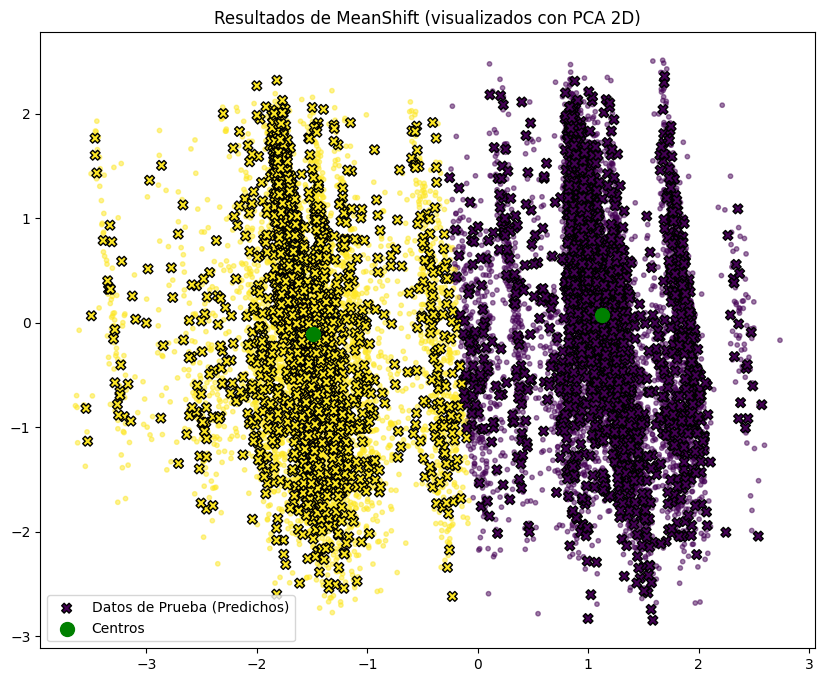

k-means++
Etiquetas reales: [0 1 2 3]
Cluster 0: etiquetas reales [0, 0, 2, 0, 1, ..., 0, 0, 3, 2, 0]
Length: 5788
Categories (4, int64): [0 < 1 < 2 < 3]
Cluster 0: etiqueta dominante 0
Cluster 1: etiquetas reales [2, 1, 2, 2, 1, ..., 3, 3, 2, 1, 3]
Length: 7685
Categories (4, int64): [0 < 1 < 2 < 3]
Cluster 1: etiqueta dominante 2
Mapa de clusters a etiquetas reales: {np.int32(0): np.int64(0), np.int32(1): np.int64(2)}
Clusters predichos para datos de prueba: [1 1 1 ... 0 1 0]
Etiquetas predichas para datos de prueba: [2 2 2 ... 0 2 0]
Accuracy: 0.3113683585633719
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.56      0.41       828
           1       0.00      0.00      0.00       827
           2       0.30      0.65      0.41       898
           3       0.00      0.00      0.00       816

    accuracy                           0.31      3369
   macro avg       0.16      0.30      0.21      3369
weighted avg       0.16  

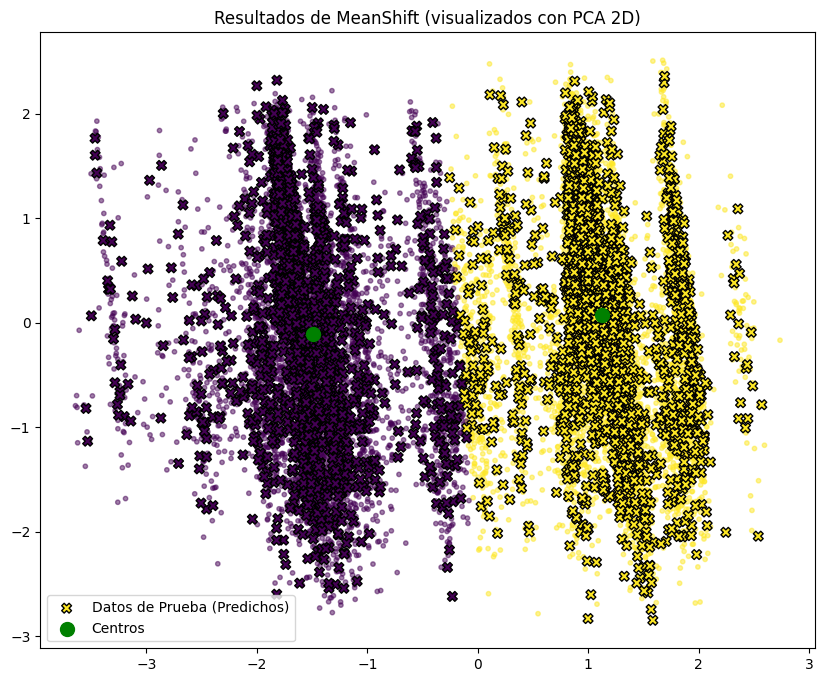

Meanshift
Etiquetas reales: [0 1 2 3]
Cluster 0: etiquetas reales [2, 1, 2, 2, 1, ..., 3, 3, 2, 1, 3]
Length: 8030
Categories (4, int64): [0 < 1 < 2 < 3]
Cluster 0: etiqueta dominante 2
Cluster 1: etiquetas reales [0, 0, 2, 0, 1, ..., 0, 0, 3, 2, 0]
Length: 5443
Categories (4, int64): [0 < 1 < 2 < 3]
Cluster 1: etiqueta dominante 0
Mapa de clusters a etiquetas reales: {np.int64(0): np.int64(2), np.int64(1): np.int64(0)}
Clusters predichos para datos de prueba: [0 0 0 ... 1 0 1]
Etiquetas predichas para datos de prueba: [2 2 2 ... 0 2 0]
Accuracy: 0.29593351142772334
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.49      0.37       828
           1       0.00      0.00      0.00       827
           2       0.29      0.66      0.40       898
           3       0.00      0.00      0.00       816

    accuracy                           0.30      3369
   macro avg       0.15      0.29      0.19      3369
weighted avg       0.15 

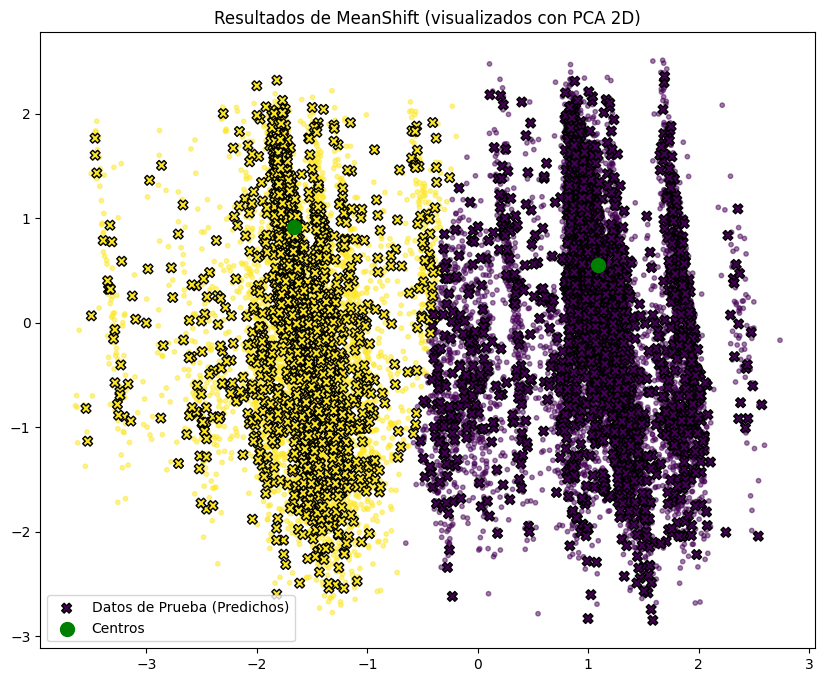

In [ ]:

for item in top_3_scores:
    modelo = item[0]
    score = item[1]
    if isinstance(modelo, MeanShift):
        print("Meanshift")
        test(modelo, test_data, "MeanShift")
    elif isinstance(modelo, KMeans):
        if modelo.init == "k-means++":
            print("k-means++")
            test(modelo, test_data, "KMeans ++")
        else:
            print("kmeans")
            test(modelo, test_data, "KMeans")